In [1]:
!unzip digits_IA_embarque.zip

Archive:  digits_IA_embarque.zip
   creating: digits/
   creating: digits/digits0/
  inflating: digits/digits0/digit_0.png  
  inflating: digits/digits0/digit_1.png  
  inflating: digits/digits0/digit_10.png  
  inflating: digits/digits0/digit_11.png  
  inflating: digits/digits0/digit_12.png  
  inflating: digits/digits0/digit_13.png  
  inflating: digits/digits0/digit_14.png  
  inflating: digits/digits0/digit_15.png  
  inflating: digits/digits0/digit_16.png  
  inflating: digits/digits0/digit_17.png  
  inflating: digits/digits0/digit_18.png  
  inflating: digits/digits0/digit_19.png  
  inflating: digits/digits0/digit_2.png  
  inflating: digits/digits0/digit_3.png  
  inflating: digits/digits0/digit_4.png  
  inflating: digits/digits0/digit_5.png  
  inflating: digits/digits0/digit_6.png  
  inflating: digits/digits0/digit_7.png  
  inflating: digits/digits0/digit_8.png  
  inflating: digits/digits0/digit_9.png  
   creating: digits/digits1/
  inflating: digits/digits1/digit_0.pn

['digits0', 'digits1', 'digits2', 'digits3', 'digits4', 'digits5', 'digits6', 'digits7', 'digits8', 'digits9']
{'digits0': 0, 'digits1': 1, 'digits2': 2, 'digits3': 3, 'digits4': 4, 'digits5': 5, 'digits6': 6, 'digits7': 7, 'digits8': 8, 'digits9': 9}


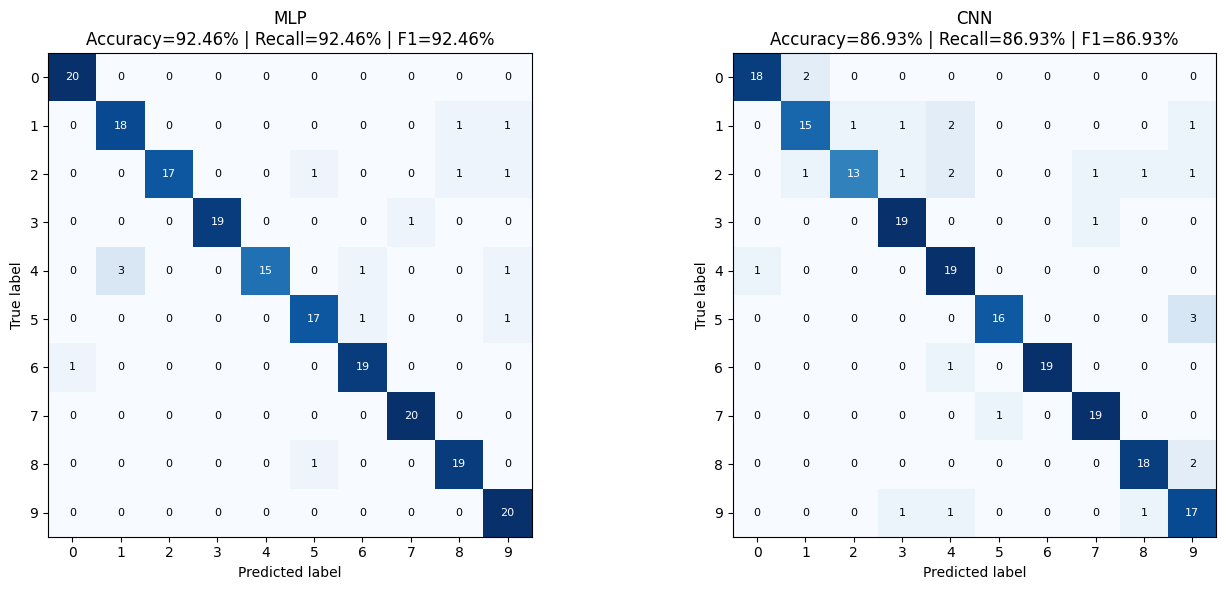

In [2]:
from torch import dtype
import cv2
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Optimizer
from sklearn.metrics import  confusion_matrix, accuracy_score,f1_score,recall_score


from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
def preprocess_perso_image(image):
  image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  image=255-image
  blur=cv2.GaussianBlur(image,(3,3),0)
  _,bin=cv2.threshold(blur,125,255,cv2.THRESH_BINARY_INV)
  contours,_=cv2.findContours(bin.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  best=max(contours,key=cv2.contourArea)
  x,y,w,h=cv2.boundingRect(best)
  roi=bin[y:y+h,x:x+w]

  s=max(w,h)
  square=np.zeros((s,s),dtype=np.uint8)
  dx=(s-w)//2
  dy=(s-h)//2
  square[dy:dy+h,dx:dx+w]=roi

  img28=cv2.resize(square,(28,28))
  return img28.astype(np.float32)/255.0

class perso_dataset(Dataset):
  def __init__(self,root,transform=None):
    self.dataset=ImageFolder(root=root,transform=transform)
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, index):
    img,label=self.dataset[index][0],self.dataset[index][1]
    img=np.array(img,dtype=np.uint8)
    img=preprocess_perso_image(img)
    x=torch.from_numpy(img).unsqueeze(0)
    return x,label



class module_CNN(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.layer1=nn.Sequential(
        nn.Conv2d(1,1,kernel_size=5,stride=1,padding=2),
        nn.ReLU()
    )
    self.layer2=nn.Sequential(
        nn.Conv2d(1,1,kernel_size=5,stride=1,padding=2),
        nn.ReLU()
    )
    self.layer3=nn.Linear(28*28,num_classes)

  def forward(self,x):
    out=self.layer1(x)
    out=self.layer2(out)
    out=self.layer3(out.flatten(start_dim=1))
    return out

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)   # aplatir l’image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_MLP=MLP().to(device)
model_cnn=module_CNN(10).to(device)

model_MLP.load_state_dict(torch.load("mlp_weights.pth",map_location=torch.device("cpu")))
model_cnn.load_state_dict(torch.load("CNN_weights.pth", map_location=torch.device("cpu")))


def preprocess_perso_image(image):
  image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  image=255-image
  blur=cv2.GaussianBlur(image,(3,3),0)
  _,bin=cv2.threshold(blur,125,255,cv2.THRESH_BINARY_INV)
  contours,_=cv2.findContours(bin.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  best=max(contours,key=cv2.contourArea)
  x,y,w,h=cv2.boundingRect(best)
  roi=bin[y:y+h,x:x+w]

  s=max(w,h)
  square=np.zeros((s,s),dtype=np.uint8)
  dx=(s-w)//2
  dy=(s-h)//2
  square[dy:dy+h,dx:dx+w]=roi

  img28=cv2.resize(square,(28,28))
  return img28.astype(np.float32)/255.0

class perso_dataset(Dataset):
  def __init__(self,root,transform=None):
    self.dataset=ImageFolder(root=root,transform=transform)
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, index):
    img,label=self.dataset[index][0],self.dataset[index][1]
    img=np.array(img,dtype=np.uint8)
    img=preprocess_perso_image(img)
    x=torch.from_numpy(img).unsqueeze(0)
    return x,label


dataset=perso_dataset(root='digits')
print(dataset.dataset.classes)
print(dataset.dataset.class_to_idx)

test_loader=DataLoader(dataset,batch_size=64,shuffle=False)


def eval_model(model,loader,device):
  y_true=[]
  y_pred=[]

  model.eval()
  with torch.no_grad():
    for x,y in loader:
      x,y=x.to(device),y.to(device)
      pred=model(x)
      pred=torch.argmax(pred, dim=1)
      y_true.extend(y.cpu().numpy().tolist())
      y_pred.extend(pred.cpu().numpy().tolist())
    accuracy=accuracy_score(y_true,y_pred)
    recall=recall_score(y_true,y_pred,average='micro')
    f1=f1_score(y_true,y_pred,average ='micro')
    cm=confusion_matrix(y_true,y_pred)
  return accuracy,f1,cm,recall

# Note: The order of returned values from eval_model is (accuracy, f1, cm, recall).
# The models list needs to reflect this for correct unpacking.
acc_mlp, f1_mlp, cm_mlp, rec_mlp = eval_model(model_MLP, test_loader, device) # Corrected assignment order
acc_cnn, f1_cnn, cm_cnn, rec_cnn = eval_model(model_cnn, test_loader, device) # Corrected assignment order
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Corrected order in the models list to match (name, confusion_matrix, accuracy, recall, f1_score)
models = [
    ("MLP", cm_mlp, acc_mlp, rec_mlp, f1_mlp),
    ("CNN", cm_cnn, acc_cnn, rec_cnn, f1_cnn),
]

for ax, (name, cm, acc, rec, f1) in zip(axes, models):
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_title(
        f"{name}\n"
        f"Accuracy={acc*100:.2f}% | Recall={rec*100:.2f}% | F1={f1*100:.2f}%"
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))

    # écrire les valeurs dans la matrice
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8
            )


plt.tight_layout()
plt.show()